# Code File for Plotting of the Meteorological Data

The data is generated from Meteonorm, providing an average weather for the location between 1990 and 2010.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import data from .dat file
Generated from Meteonorm

In [13]:
# Load data
file_path = 'Data_files/bolgatanga_data.dat'
df = pd.read_csv(file_path, sep=',', skipinitialspace=True)

# Parse datetime and create season labels
df['date'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['season'] = df['month'].apply(lambda x: 'Rainy' if 5 <= x <= 10 else 'Dry')

# Calculations:
Calculate the average temperature, rainfall, and sunshine hours for the two seasons

In [3]:
# Rainfall data collected online at: https://gjstd.org/index.php/GJSTD/article/view/168 
rainfall_mm = [0.19, 2.06, 15.86, 41.76, 109.87, 132.89, 170.80, 248.71, 176.77, 61.35, 4.24, 2.52]

# Add the rainfall to the DataFrame for alignment
df['rainfall'] = df['month'].apply(lambda x: rainfall_mm[x - 1])  # Match rainfall to months

# Define rainy and dry season masks
rainy_season = df['month'].between(5, 10)  # May to October
dry_season = ~rainy_season  # All other months

# Calculate averages for rainy and dry seasons
rainy_avg_temp = df.loc[rainy_season, 'temp'].mean() # Average temp. rainy season
dry_avg_temp = df.loc[dry_season, 'temp'].mean() # Average temp. dry season 
dry_temp_max = df.loc[dry_season, 'temp'].max() # Max temp. dry season
rainy_avg_rainfall = df.loc[rainy_season, 'rainfall'].mean() # Average rainfall rainy season
dry_avg_rainfall = df.loc[dry_season, 'rainfall'].mean() # Average rainfall dry season
rainy_avg_sun_hours = df.loc[rainy_season, 'sunshine_duration'].mean() # Average sunshine duration rainy season
dry_avg_sun_hours = df.loc[dry_season, 'sunshine_duration'].mean() # Average sunshine duration dry season

# Display the results:
print("Rainy Season:")
print(f"- Avg. Temperature: {rainy_avg_temp:.2f}°C")
print(f"- Avg. Rainfall: {rainy_avg_rainfall:.2f} mm")
print(f"- Avg. Sun Hours: {rainy_avg_sun_hours:.2f} hours")

print("\nDry Season:")
print(f"- Avg. Temperature: {dry_avg_temp:.2f}°C")
print(f"- Avg. Rainfall: {dry_avg_rainfall:.2f} mm")
print(f"- Avg. Sun Hours: {dry_avg_sun_hours:.2f} hours")
print(f"\nHighest temp:{dry_temp_max:.2f}")

Rainy Season:
- Avg. Temperature: 28.64°C
- Avg. Rainfall: 150.01 mm
- Avg. Sun Hours: 16.85 hours

Dry Season:
- Avg. Temperature: 29.12°C
- Avg. Rainfall: 11.12 mm
- Avg. Sun Hours: 21.57 hours

Highest temp:43.00


# Plot section:
Plot of the monthly climatology for the region 

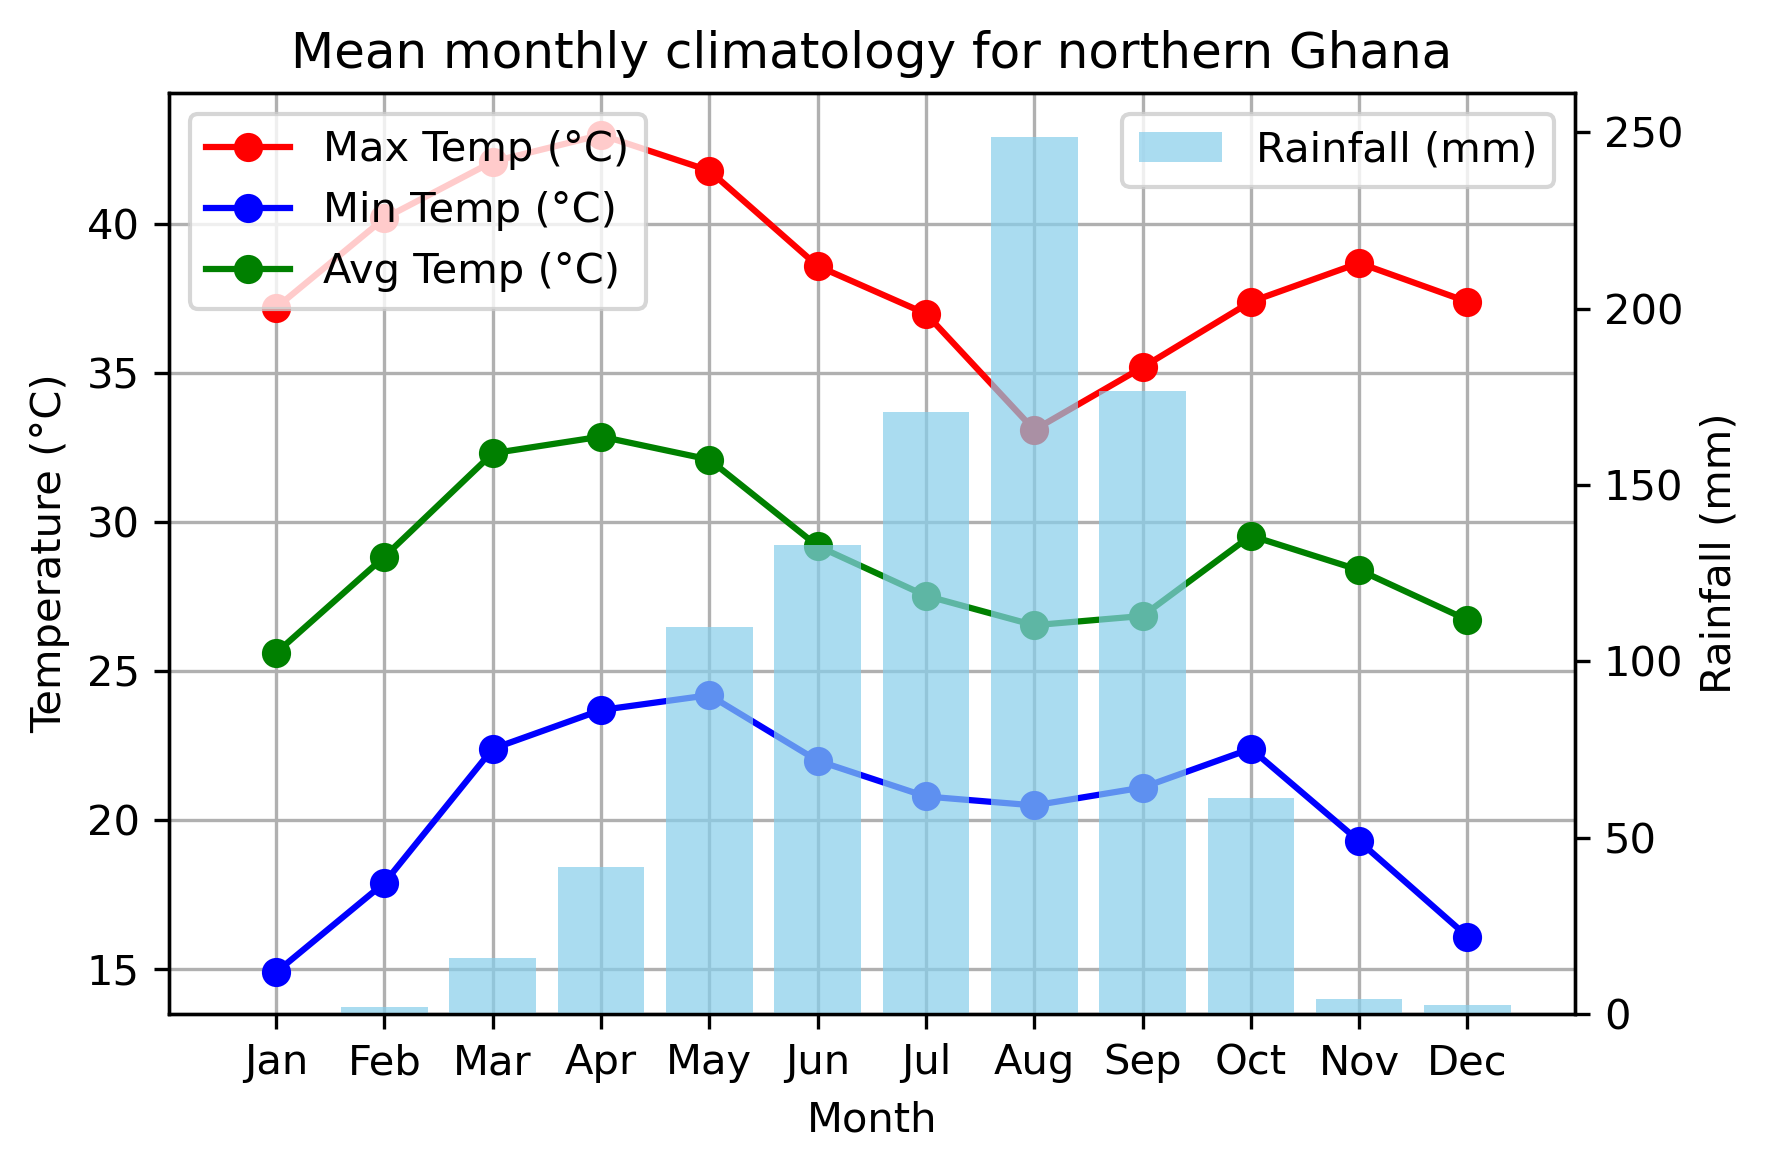

In [14]:
# Calculate monthly climatology for temperature
monthly_stats = df.groupby('month').agg(
    max_temp=('temp', 'max'),
    min_temp=('temp', 'min'),
    avg_temp=('temp', 'mean'),
    avg_humidity=('humidity', 'mean')
).reset_index()

# Add rainfall data to the monthly stats DataFrame
monthly_stats['Rainfall (mm)'] = rainfall_mm
monthly_stats['Month Name'] = [
    "Jan", "Feb", "Mar", "Apr", "May", "Jun", 
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
]

# Plotting
fig, ax1 = plt.subplots(figsize=(6, 4), dpi=300)

# Plot temperatures
ax1.plot(monthly_stats['Month Name'], monthly_stats['max_temp'], label="Max Temp (°C)", color="red", marker="o")
ax1.plot(monthly_stats['Month Name'], monthly_stats['min_temp'], label="Min Temp (°C)", color="blue", marker="o")
ax1.plot(monthly_stats['Month Name'], monthly_stats['avg_temp'], label="Avg Temp (°C)", color="green", marker="o")
ax1.set_xlabel("Month")
ax1.set_ylabel("Temperature (°C)")
ax1.legend(loc="upper left")
ax1.grid()

# Create a secondary y-axis for rainfall
ax2 = ax1.twinx()
ax2.bar(monthly_stats['Month Name'], monthly_stats['Rainfall (mm)'], label="Rainfall (mm)", color="skyblue", alpha=0.7)
#ax2.plot(monthly_stats['Month Name'], monthly_stats['avg_humidity'], label="Avg Humidity (%)", color="purple", marker="s", linestyle="--")
ax2.set_ylabel("Rainfall (mm)")
ax2.legend(loc="upper right")

plt.title("Mean monthly climatology for northern Ghana")
plt.tight_layout()
plt.show()


Plot of the peak sun hours for each month

Average Peak Sun Hours during Rainy Season: 5.85 hours
Average Peak Sun Hours during Dry Season: 6.05 hours
Day with the lowest Peak Sun Hours: 2005-09-01
Lowest Peak Sun Hours: 1.16 hours/day


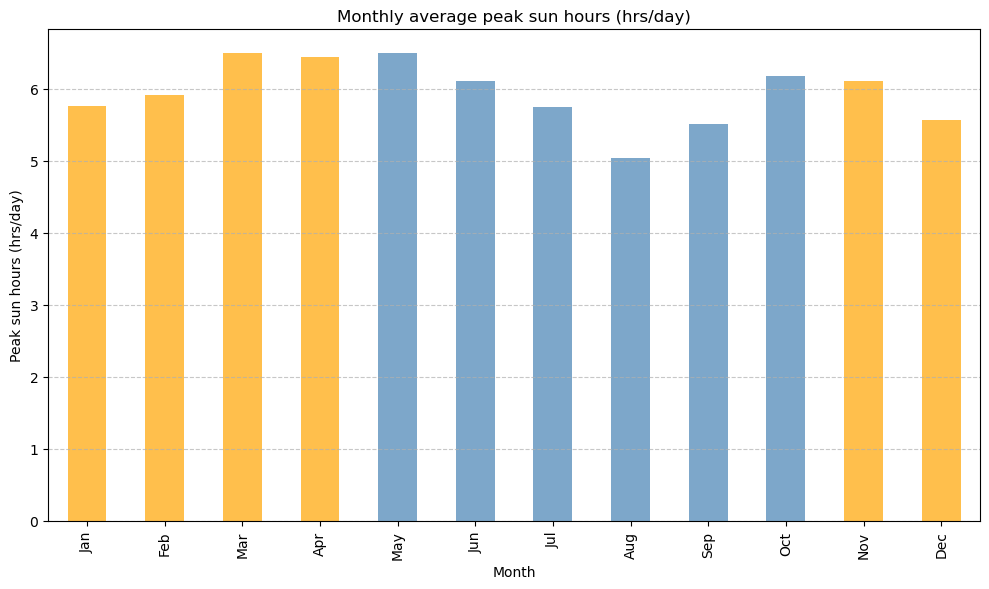

In [19]:
# Calculate daily total solar energy (GRH) in Wh/m² and daily peak sun hours
df['daily_GRH'] = df.groupby(['year', 'month', 'day'])['GRH'].transform('sum')  # Total daily GRH
df['daily_peak_sun_hours'] = df['daily_GRH'] / 1000  # Convert to Peak Sun Hours (hrs/day)


# Calculate seasonal averages for peak sun hours
rainy_avg_peak_sun_hours = df.loc[rainy_season].groupby(['year', 'month', 'day'])['daily_peak_sun_hours'].mean().mean()
dry_avg_peak_sun_hours = df.loc[dry_season].groupby(['year', 'month', 'day'])['daily_peak_sun_hours'].mean().mean()

# Display results
print(f"Average Peak Sun Hours during Rainy Season: {rainy_avg_peak_sun_hours:.2f} hours")
print(f"Average Peak Sun Hours during Dry Season: {dry_avg_peak_sun_hours:.2f} hours")
# Find the day with the lowest peak sun hours
lowest_peak_sun_hours_day = df.loc[df['daily_peak_sun_hours'].idxmin(), ['year', 'month', 'day', 'daily_peak_sun_hours']]

# Display the result
print(f"Day with the lowest Peak Sun Hours: {int(lowest_peak_sun_hours_day['year'])}-{int(lowest_peak_sun_hours_day['month']):02d}-{int(lowest_peak_sun_hours_day['day']):02d}")
print(f"Lowest Peak Sun Hours: {lowest_peak_sun_hours_day['daily_peak_sun_hours']:.2f} hours/day")

# Calculate mean daily peak sun hours for each month
df['month_name'] = df['month'].apply(lambda x: ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"][x - 1])
monthly_peak_sun_hours = df.groupby('month_name')['daily_peak_sun_hours'].mean()

# Sort months for proper order
monthly_peak_sun_hours = monthly_peak_sun_hours.reindex(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
                                                         "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
# Color coding for seasons
colors = ['orange' if month in ["Nov", "Dec", "Jan", "Feb", "Mar", "Apr"] else 'steelblue' for month in monthly_peak_sun_hours.index]

# Plot
plt.figure(figsize=(10, 6))
monthly_peak_sun_hours.plot(kind='bar', color=colors, alpha=0.7)
plt.title('Monthly average peak sun hours (hrs/day)')
plt.xlabel('Month')
plt.ylabel('Peak sun hours (hrs/day)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Plot of the daily PV production potential

Actual Average Daily PV Production (Rainy Season): 89.64 kWh
Actual Average Daily PV Production (Dry Season): 92.22 kWh
Final Corrected Average Daily Sum of GRT (Rainy Season): 5847.60 W/m²*h
Final Corrected Average Daily Sum of GRT (Dry Season): 6015.75 W/m²*h
Expected Average Daily PV Production (Rainy Season): 89.64 kWh
Expected Average Daily PV Production (Dry Season): 92.22 kWh
Efficiency Factor (Rainy Season): 100.00%
Efficiency Factor (Dry Season): 100.00%


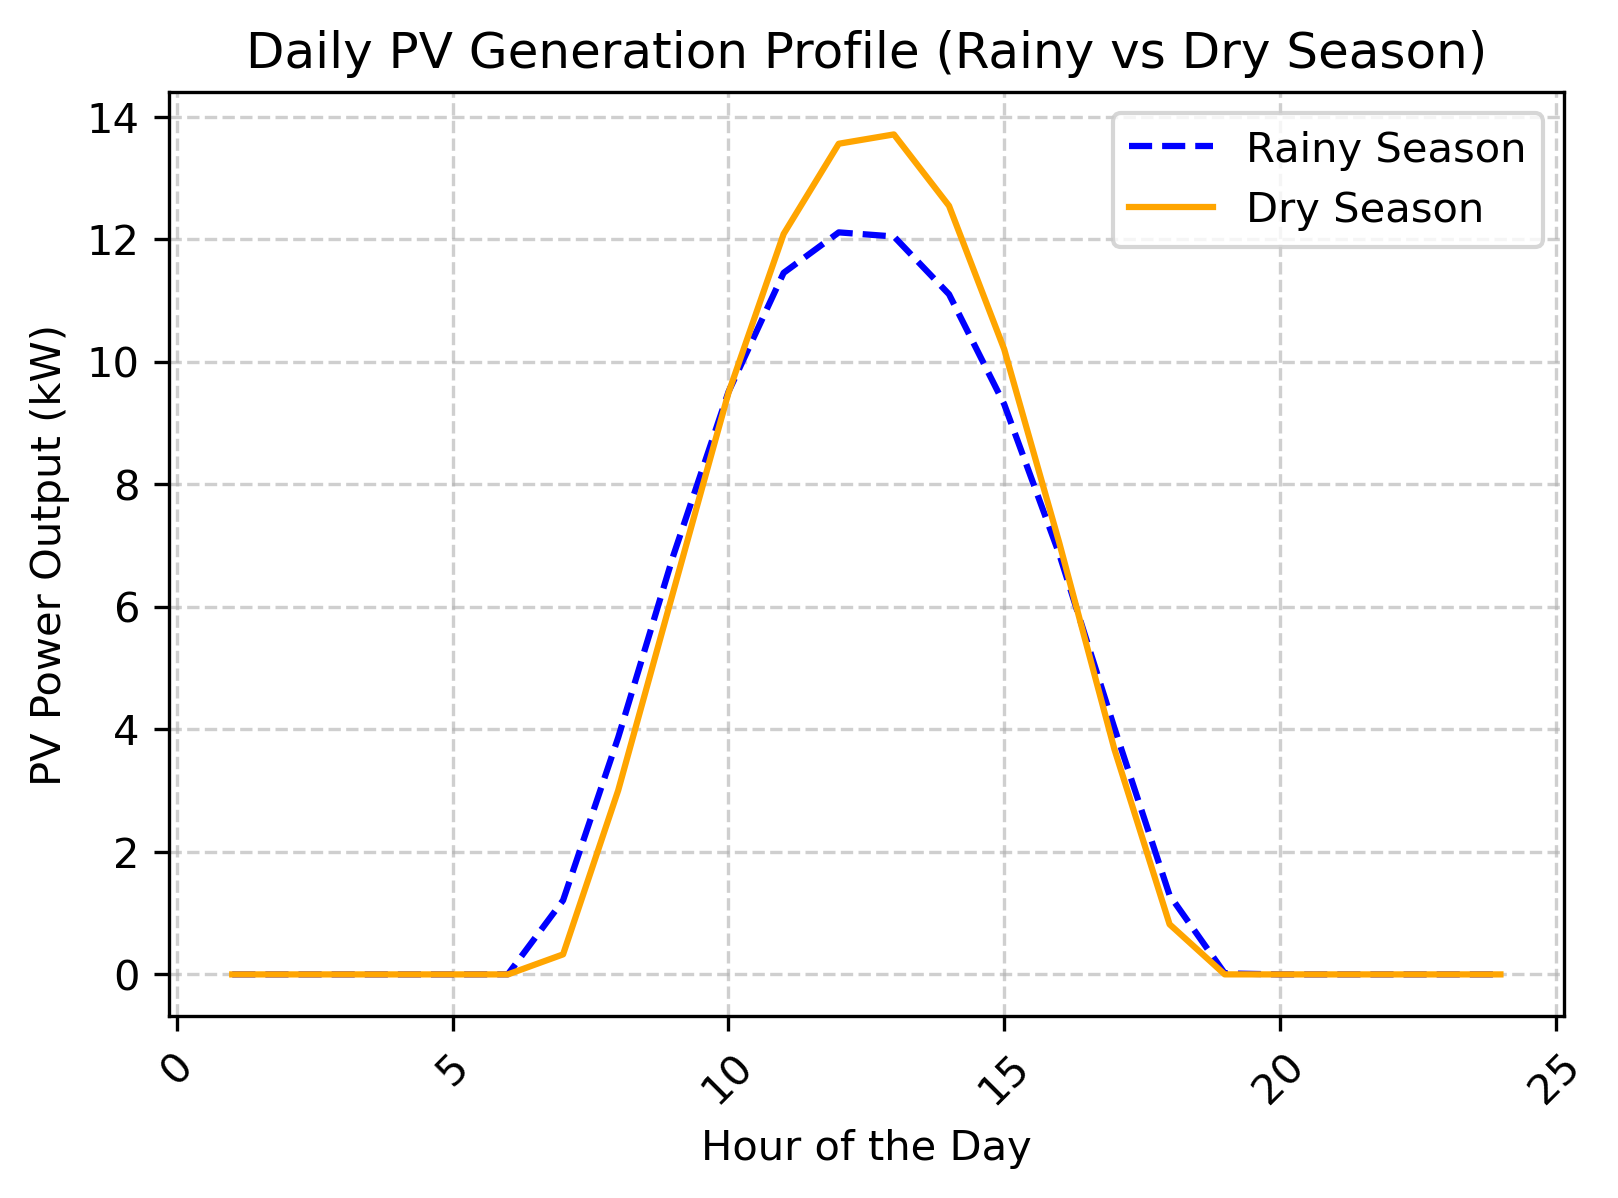

In [26]:
# PV system parameters
A_565Wp = 12 * (2.278 * 1.134)  # Total area for 565Wp modules (m²)
A_285Wp = 30 * (1.670 * 1.000)  # Total area for 285Wp modules (m²)
A_total = A_565Wp + A_285Wp  # Total panel area

eta_565Wp = 565 / (2.278 * 1.134 * 1000)  # Efficiency of 565 Wp modules
eta_285Wp = 285 / (1.670 * 1.000 * 1000)  # Efficiency of 285 Wp modules
eta_weighted = (eta_565Wp * A_565Wp + eta_285Wp * A_285Wp) / A_total  # Weighted efficiency

# Compute PV output for each module type
df["PV_output_565Wp"] = (df["GRT"] * A_565Wp / 1000) * eta_565Wp
df["PV_output_285Wp"] = (df["GRT"] * A_285Wp / 1000) * eta_285Wp

# Total PV generation (in kWh)
df["PV_output_total"] = df["PV_output_565Wp"] + df["PV_output_285Wp"]

# Group by date and sum values for **daily totals**
daily_data = df.groupby(["date", "season"]).agg(
    daily_GRT=("GRT", "sum"),  # Sum total daily solar radiation (W/m²*h)
    daily_PV_kWh=("PV_output_total", "sum")  # Sum total daily PV production (kWh)
).reset_index()

# Compute actual daily PV production per season
average_rainy_kWh = daily_data[daily_data["season"] == "Rainy"]["daily_PV_kWh"].mean()
average_dry_kWh = daily_data[daily_data["season"] == "Dry"]["daily_PV_kWh"].mean()

print(f"Actual Average Daily PV Production (Rainy Season): {average_rainy_kWh:.2f} kWh")
print(f"Actual Average Daily PV Production (Dry Season): {average_dry_kWh:.2f} kWh")

# Compute average daily sum of GRT per season
avg_GRT_rainy = daily_data[daily_data["season"] == "Rainy"]["daily_GRT"].mean()
avg_GRT_dry = daily_data[daily_data["season"] == "Dry"]["daily_GRT"].mean()

print(f"Final Corrected Average Daily Sum of GRT (Rainy Season): {avg_GRT_rainy:.2f} W/m²*h")
print(f"Final Corrected Average Daily Sum of GRT (Dry Season): {avg_GRT_dry:.2f} W/m²*h")

# Compute expected daily PV production using total daily GRT
expected_rainy_kWh = (avg_GRT_rainy * A_total * eta_weighted) / 1000
expected_dry_kWh = (avg_GRT_dry * A_total * eta_weighted) / 1000

print(f"Expected Average Daily PV Production (Rainy Season): {expected_rainy_kWh:.2f} kWh")
print(f"Expected Average Daily PV Production (Dry Season): {expected_dry_kWh:.2f} kWh")

# Compare expected vs actual production
efficiency_factor_rainy = (average_rainy_kWh / expected_rainy_kWh) * 100
efficiency_factor_dry = (average_dry_kWh / expected_dry_kWh) * 100

print(f"Efficiency Factor (Rainy Season): {efficiency_factor_rainy:.2f}%")
print(f"Efficiency Factor (Dry Season): {efficiency_factor_dry:.2f}%")

# Plot the daily profile
rainy_profile = df[df["season"] == "Rainy"].groupby("hour")["PV_output_total"].mean()
dry_profile = df[df["season"] == "Dry"].groupby("hour")["PV_output_total"].mean()

plt.figure(figsize=(6, 4), dpi=300)
plt.plot(rainy_profile, label="Rainy Season", color="blue", linestyle="--")
plt.plot(dry_profile, label="Dry Season", color="orange")

plt.title("Daily PV Generation Profile (Rainy vs Dry Season)")
plt.xlabel("Hour of the Day")
plt.ylabel("PV Power Output (kW)")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()